In [1]:
import os 
os.chdir("..")


In [2]:
%load_ext autoreload
%autoreload 2
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time
from scipy.special import erf
import pickle

In [3]:
mode = "damping"
dtt = 1e-6
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)

total_time, dt = get_total_time_dt(params, ppp=1000, dt=dtt, total_time=10.)
times = np.arange(0, total_time+ dt, dt)

In [4]:

def load_liks(itrajj, mode="damping", dtt=1e-6, total_time=4.):
    pars = give_def_params_discrimination(flip=0, mode = mode, )
    params, exp_path = check_params_discrimination(pars)

    total_time, dt = get_total_time_dt(params, ppp=1000, dt=dtt, total_time = total_time)
    
    logliks =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    l0,l1 = logliks[:,0], logliks[:,1]
    log_lik_ratio = l1 - l0  ###

    pars = give_def_params_discrimination(flip=1, mode=mode)
    params, exp_path = check_params_discrimination(pars)
    total_time, dt = get_total_time_dt(params, ppp=1000,dt=dtt ,total_time = total_time)
    logliks_swap =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    log_lik_ratio_swap = logliks_swap[:,0] - logliks_swap[:,1]  
    
    return log_lik_ratio, log_lik_ratio_swap


indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]

def get_stop_time(ell,b):
    logicals = np.logical_and(ell < b, ell > -b)
    if np.sum(logicals) == 0:
        return np.nan
    else:
        ind_times = np.argmin(logicals)
        return times[ind_times]

In [5]:
mode="damping"
Ntrajs=100
dtt=1e-6
total_time=4.

In [30]:
Ntraj = 2000

stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}

ers = []
total_time = 4.
dt = 1e-6
times = np.arange(0,dt+total_time, dt)
l0,l1 = np.zeros((2,len(times)+1))

boundsB= np.arange(3,8,1)

for itraj in tqdm(range(1,Ntraj)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj, mode=mode, dtt=1e-6, total_time=4.)
        for b in boundsB:
            stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b))
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
    except Exception:
        ers.append(itraj)
l0/=(Ntraj - len(ers))
l1/=(Ntraj - len(ers))

100%|██████████| 1999/1999 [07:38<00:00,  4.36it/s]


In [31]:
stops = []
for k in stop["_1"].values():
    if len(k) != 0:
        stops.append(k)
stops = np.squeeze(stops)

In [146]:
path = get_def_path()+"results_stopping_time/damping/{}_stats/".format(stops.shape)
path_data = get_def_path()+"results_stopping_time/damping/{}_stats/data/".format(stops.shape)
os.makedirs(path,exist_ok=True)
os.makedirs(path_data,exist_ok=True)



In [ ]:
cons = []
anals = []
timbin = []
timanals = []
for indb, b in enumerate(boundsB):
    counts, bins = np.histogram(stops[:,indb], 50, normed=True)
    timms = np.linspace(0,np.max(bins), 100)
    gp1 =[prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in timms]
    timbins = .5*(bins[1:] + bins[:-1])
    cons.append(counts)
    anals.append(gp1)
    timbin.append(timbins)
    timanals.append(timms)

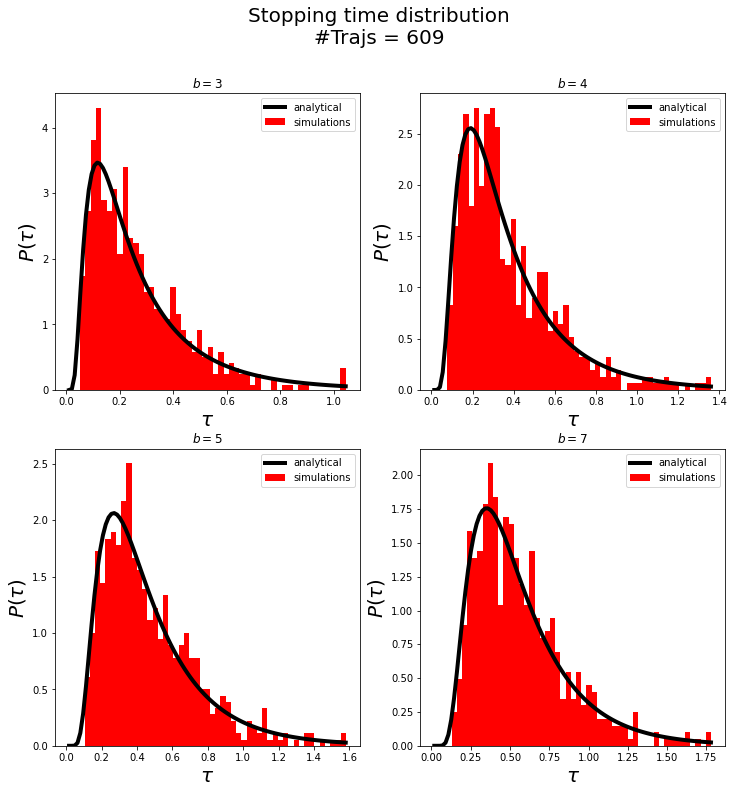

In [152]:
plt.figure(figsize=(12,12))
plt.suptitle("Stopping time distribution\n#Trajs = {}".format(len(stops)),size=20)
axx = [221, 222, 223, 224]
selected_b = [boundsB[int(k)] for k in np.linspace(0,len(boundsB)-1, 4)]
for indb, b in enumerate(selected_b):
    ax = plt.subplot(axx[indb])
    ax.set_title('$b=$'+str(np.round(b,2)))
    ax.plot(timanals[indb], anals[indb], linewidth=4, color="black", label="analytical")
    ax.bar(timbin[indb], cons[indb], width=timbin[indb][1]-timbin[indb][0], color="red", label="simulations")
    ax.set_xlabel(r'$\tau$',size=20)
    ax.set_ylabel(r'$P(\tau)$', size=20)
    ax.legend(prop={"size":10})
plt.savefig(path+"stopping_times.pdf")

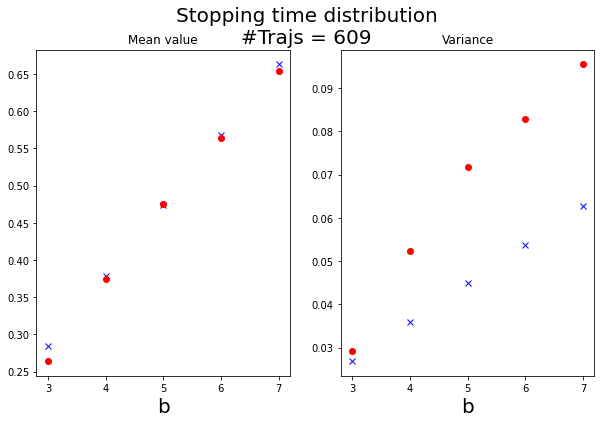

In [171]:
plt.figure(figsize=(10,6))
plt.suptitle("Stopping time distribution\n#Trajs = {}".format(len(stops)),size=20)
ax=plt.subplot(121)
ax.set_title("Mean value")
ax.plot(boundsB,boundsB/mu, 'x', color="blue", label="analytical")
ax.plot(boundsB,np.mean(stops,axis=0), 'o',color="red", label="numerics")
ax.set_xlabel("b", size=20)
ax=plt.subplot(122)
ax.set_title("Variance")
ax.plot(boundsB,boundsB/(mu**2), 'x', color="blue", label="analytical")
ax.plot(boundsB,np.std(stops,axis=0)**2, 'o',color="red", label="numerics")
ax.set_xlabel("b", size=20)
plt.savefig(path+"stopping_times_moments.pdf")

In [202]:

mode = "damping"
dtt = 1e-6
total_time = 4.
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)


Ntraj = 2000

stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]

er=[]
deter = {}
deter["h0/h1"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}


total_time, dt = get_total_time_dt(params, ppp=1000, dt=dtt, total_time=total_time)
times = np.arange(0, total_time+ dt, dt)
l0,l1 = np.zeros((2,len(times)+1))

indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]


boundsB= np.arange(.5,4.5,.1)
n=1
ers = []
for itraj in tqdm(range(1,Ntraj)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj, mode=mode, dtt=dt, total_time=total_time)
        
        for indb,b in enumerate(boundsB):
            stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b))
            stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))
            
            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b
                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
l0/=(Ntraj - len(ers))
l1/=(Ntraj - len(ers))

100%|██████████| 1999/1999 [10:39<00:00,  3.12it/s]


[0.028756, 0.043239, 0.053391, 0.056160999999999996, 0.074947]

In [204]:
path = get_def_path()+"results_stopping_time/damping/{}_stats/".format(stops.shape)
path_data = get_def_path()+"results_stopping_time/damping/{}_stats/data/".format(stops.shape)
os.makedirs(path,exist_ok=True)
os.makedirs(path_data,exist_ok=True)

with open(path_data+"stop.pickle","wb") as f:
    pickle.dump(stop, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(path_data+"deter.pickle","wb") as f:
    pickle.dump(deter, f, protocol=pickle.HIGHEST_PROTOCOL)
np.save(path_data+"timbin", timbin)
np.save(path_data+"timanals", timanals)
np.save(path_data+"cons", cons)
np.save(path_data+"anals", anals)

In [206]:
stops = []
for k in stop["_1"].values():
    if len(k) != 0:
        stops.append(k)
stops = np.squeeze(stops)


cons = []
anals = []
timbin = []
timanals = []
for indb, b in enumerate(boundsB):

    counts, bins = np.histogram(stops[:,indb], 50, normed=True)
    timms = np.linspace(0,np.max(bins), 100)
    gp1 =[prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in timms]
    timbins = .5*(bins[1:] + bins[:-1])
    cons.append(counts)
    anals.append(gp1)
    timbin.append(timbins)
    timanals.append(timms)

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


IndexError: index 5 is out of bounds for axis 1 with size 5

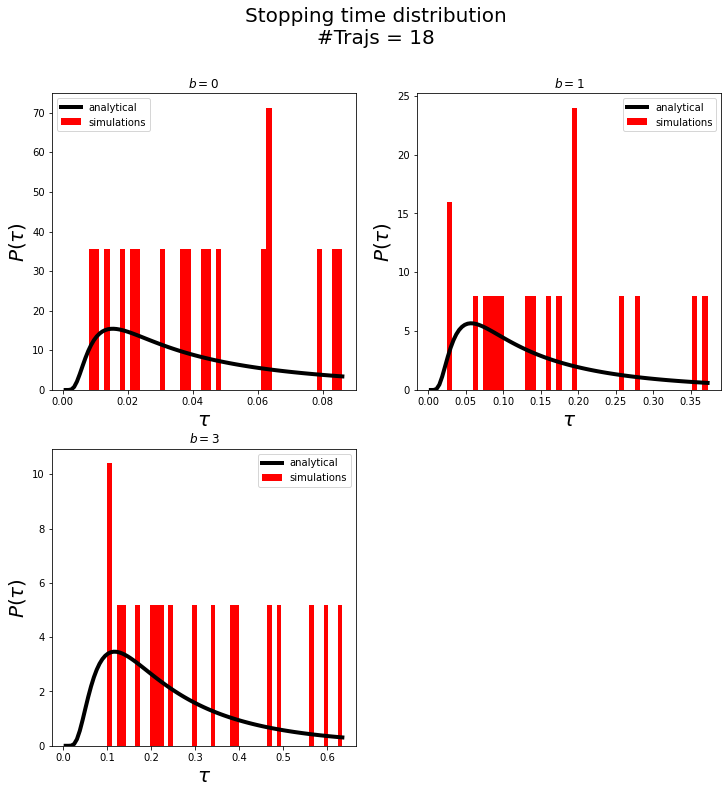

In [201]:
plt.figure(figsize=(12,12))
plt.suptitle("Stopping time distribution\n#Trajs = {}".format(len(stops)),size=20)
axx = [221, 222, 223, 224]
selected_b = [boundsB[int(k)] for k in np.linspace(0,len(boundsB)-1, 3)]
for indb, b in enumerate(selected_b):
    ax = plt.subplot(axx[indb])
    ax.set_title('$b=$'+str(np.round(b,2)))
    ax.plot(timanals[indb], anals[indb], linewidth=4, color="black", label="analytical")
    ax.bar(timbin[indb], cons[indb], width=timbin[indb][1]-timbin[indb][0], color="red", label="simulations")
    ax.set_xlabel(r'$\tau$',size=20)
    ax.set_ylabel(r'$P(\tau)$', size=20)
    ax.legend(prop={"size":10})
#plt.savefig(path+"stopping_times.pdf")

In [ ]:
stops = []
for k in stop["_0"].values():
    if len(k) != 0:
        stops.append(k)
stops = np.squeeze(stops)


cons = []
anals = []
timbin = []
timanals = []
for indb, b in enumerate(boundsB):
    if indb != 0:

        counts, bins = np.histogram(stops[:,indb], 50, normed=True)
        timms = np.linspace(0,np.max(bins), 100)
        gp1 =[prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in timms]
        timbins = .5*(bins[1:] + bins[:-1])
        cons.append(counts)
        anals.append(gp1)
        timbin.append(timbins)
        timanals.append(timms)

In [179]:
indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]


er=[]
deter = {}
deter["h0/h1"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

for itraj in range(1, 100):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj, mode="damping", dtt=1e-6, total_time=4.)
        for time_index in tqdm(indis):
            for indb, b in enumerate(boundsB):
                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        n+=1
    except Exception:
        er.append(itraj)

  0%|          | 0/100 [00:00<?, ?it/s]


In [190]:
indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]

n=1
er=[]
deter = {}
deter["h0/h1"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

for itraj in tqdm(range(1, 1000)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj, mode="damping", dtt=1e-6, total_time=4.)
        for ind,time_index in enumerate(indis):
            for indb, b in enumerate(boundsB):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b
                
                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        n+=1
    except Exception:
        er.append(itraj)

100%|██████████| 999/999 [01:44<00:00,  9.59it/s]


In [189]:
len(deter["h0/h1"].keys())

5

In [176]:
    deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b
                deter["h0/h1"][indb].append(int(deter_1))
                deter["h1/h0"][indb].append(int(deter_0))

            log_lik_ratio = log_lik_ratio
            log_lik_ratio_swap = log_lik_ratio_swap



2000

In [ ]:
    n+=1
    for ind, time_index in enumerate(indis):
        for indb, b in enumerate(boundsB):
            deter_1 = log_lik_ratio[time_index] <= b
            deter_0 = log_lik_ratio_swap[time_index] >= b

            deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
            deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n

l_1/=Ntrajs
l_0/=Ntrajs

In [ ]:
freq_dir = get_def_path(mode="hypothesis_testing")+"mode_{}/N_trajs_{}/dt_{}_T_{}/bounds_{}/".format(mode,Ntrajs, dtt, total_time, len(boundsB))
os.makedirs(freq_dir, exist_ok=True)
with open(freq_dir+"stop.pickle", 'wb') as handle:
    pickle.dump(stop, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open(freq_dir+"deter.pickle", 'wb') as handle:
    pickle.dump(deter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
mode="damping"
boundsB = np.arange(0,4,.1)
Ntrajs=5000
dtt=1e-5
total_time=6.


freq_dir = get_def_path(mode="hypothesis_testing")+"mode_{}/N_trajs_{}/dt_{}_T_{}/bounds_{}/".format(mode,Ntrajs, dtt, total_time, len(boundsB))
with open(freq_dir+"stop.pickle", 'rb') as handle:
    stop = pickle.load(handle)
        
        
ss = stop["_1"]
sso = [ss[k] for k in list(ss.keys())]
stop1 = np.stack(sso)

FileNotFoundError: [Errno 2] No such file or directory: '/data/uab-giq/scratch/matias/quantera/trajectories/hypothesis_testing/mode_damping/N_trajs_5000/dt_1e-05_T_6.0/bounds_40/stop.pickle'

In [56]:
st = stop1[:,-1]




In [66]:
len(st)

4999

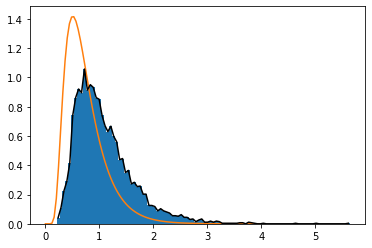

In [67]:
probs = [prob(t, 7.8,  kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in np.linspace(1e-4,4,100)]
timms = np.linspace(1e-4,4,100)
dd = timms[1] - timms[0]

counts, bins, bars = plt.hist(st, bins=100, density=True)

time_bins = (bins[1:] + bins[:-1])*0.5
db = bins[1] - bins[0]
plt.plot(np.linspace(1e-4,4,100), probs)
plt.plot(time_bins, counts, color="black")

In [69]:
mode="damping"
boundsB = np.arange(0,4,.2)
Ntrajs=1000
dtt=1e-5
total_time=6.


freq_dir = get_def_path(mode="hypothesis_testing")+"mode_{}/N_trajs_{}/dt_{}_T_{}/bounds_{}/".format(mode,Ntrajs, dtt, total_time, len(boundsB))
with open(freq_dir+"stop.pickle", 'rb') as handle:
    stop = pickle.load(handle)
        

In [70]:

        
ss = stop["_1"]
sso = [ss[k] for k in list(ss.keys())]
stop1 = np.stack(sso)

ValueError: all input arrays must have the same shape

In [72]:
er, strop = [], []
for k in range(len(sso)):
    try:
        strop.append(sso[k][19])
    except Exception:
        er.append(k)

In [74]:
st = strop


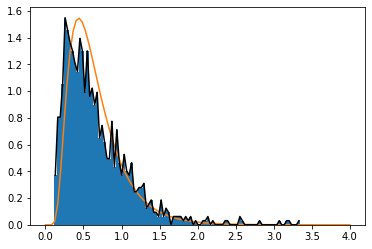

In [84]:
probs = [prob(t, 7,  kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in np.linspace(1e-4,4,100)]
timms = np.linspace(1e-4,4,100)
dd = timms[1] - timms[0]

counts, bins, bars = plt.hist(st, bins=100, density=True)

time_bins = (bins[1:] + bins[:-1])*0.5
db = bins[1] - bins[0]
plt.plot(np.linspace(1e-4,4,100), probs)
plt.plot(time_bins, counts, color="black")

In [77]:
freq_dir = get_def_path(mode="hypothesis_testing")+"{}/{}/dt{}/".format(mode,10000, 1e-5)

In [80]:
stop_time1 = np.load(freq_dir+"stop_time1.npy", allow_pickle=True)

In [82]:
np.arange(0,10,.1)/

NameError: name 'mu1' is not defined

In [10]:
stop0 = np.stack(stop["_0"].values())
stop1 = np.stack(stop["_1"].values())
mmeans = np.mean(stop1,axis=0)
sstd = np.std(stop1,axis=0)

In [11]:
stopping_0, std_stopping_0 = np.mean(stop0,axis=0), np.std(stop0,axis=0)
stopping_1, std_stopping_1 = np.mean(stop1,axis=0), np.std(stop1,axis=0)

In [14]:
import os 
freq_dir = get_def_path(mode="hypothesis_testing")+"{}/{}/dt{}/bounds{}".format(mode,len(stop["_1"]), dt, len(boundsB))
os.makedirs(freq_dir, exist_ok=True)

np.save(freq_dir+"times_here", timind)

np.save(freq_dir+"mean_likelihood_0", l_0)
np.save(freq_dir+"mean_likelihood_1", l_1)
np.save(freq_dir+"boundsB", boundsB)
np.save(freq_dir+"stop_time0",stopping_0)
np.save(freq_dir+"stop_time1",stopping_1)
np.save(freq_dir+"alpha_deter",np.array(deter["h0/h1"]))
np.save(freq_dir+"beta_deter",np.array(deter["h1/h0"]))

In [15]:
alpha = np.array(list(deter["h0/h1"].values()))
beta = np.array(list(deter["h1/h0"].values()))

Text(0.5, 0, '$P_e = \\frac{1}{2} (\\alpha + \\beta)$')

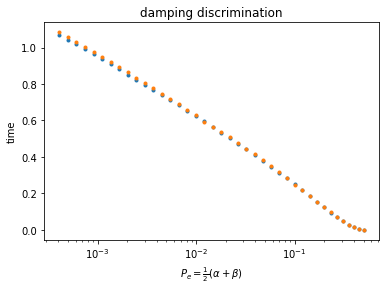

In [16]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))

ax = plt.subplot(111)
plt.title("{} discrimination".format(mode))
lin=6
ax.plot([avg_err_alpha(b) for b in boundsB],stopping_0, '.',label=r'$\langle \tau \rangle_{|H1}$', linewidth=lin)
ax.plot([avg_err_alpha(b) for b in boundsB],stopping_1, '.',label=r'$\langle \tau \rangle_{|H0}$', linewidth=lin)

ax.set_xscale("log")
ax.set_ylabel("time")
ax.set_xlabel(r'$P_e = \frac{1}{2} (\alpha + \beta)$')


In [17]:
def ggiulio_prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1):
    Su1 = n1 + 0.5 + (kappa1 / gamma1)
    Su0 = n0 + 0.5 + (kappa0 / gamma0)

    S1 = (np.sqrt(1 + (16.0*eta1*kappa1*Su1/gamma1)) - 1)*(gamma1/(8.0*eta1*kappa1))
    S0 = (np.sqrt(1 + (16.0*eta0*kappa0*Su0/gamma0)) - 1)*( gamma0/(8.0*eta0*kappa0))

    lam = gamma0 + (8*eta0*kappa0*S0)

    aa = (4*eta1*kappa1*(S1**2))/gamma1
    bb =(4*eta0*kappa0*S0**2)*(1+((16.0*eta1*kappa1*S1)/ (gamma1 + lam)) + (64.0*(eta1 * kappa1 * S1)**(2)/(gamma1 * (gamma1 + lam))))/ lam
    c =8 *(S0*S1*(eta0*kappa0 *eta1*kappa1)**(0.5)) * (gamma1+ (4.0*eta1*kappa1*S1) ) / ((gamma1 + lam)*gamma1)

    mu = 4*(eta1*kappa1*aa + (eta0*kappa0*bb) - 2*np.sqrt(eta1*kappa1*eta0*kappa0)*c)
    S= np.sqrt(2*mu)

    div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div

def drift(kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1):
    Su1 = n1 + 0.5 + (kappa1 / gamma1)
    Su0 = n0 + 0.5 + (kappa0 / gamma0)

    S1 = (np.sqrt(1 + (16.0*eta1*kappa1*Su1/gamma1)) - 1)*(gamma1/(8.0*eta1*kappa1))
    S0 = (np.sqrt(1 + (16.0*eta0*kappa0*Su0/gamma0)) - 1)*( gamma0/(8.0*eta0*kappa0))

    lam = gamma0 + (8*eta0*kappa0*S0)

    aa = (4*eta1*kappa1*(S1**2))/gamma1
    bb =(4*eta0*kappa0*S0**2)*(1+((16.0*eta1*kappa1*S1)/ (gamma1 + lam)) + (64.0*(eta1 * kappa1 * S1)**(2)/(gamma1 * (gamma1 + lam))))/ lam
    c =8 *(S0*S1*(eta0*kappa0 *eta1*kappa1)**(0.5)) * (gamma1+ (4.0*eta1*kappa1*S1) ) / ((gamma1 + lam)*gamma1)

    mu = 4*(eta1*kappa1*aa + (eta0*kappa0*bb) - 2*np.sqrt(eta1*kappa1*eta0*kappa0)*c)
    return mu 

In [18]:
pars = give_def_params_discrimination(flip=1, mode = "damping")
params, exp_path = check_params(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

mu0 = drift(kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)

pars = give_def_params_discrimination(flip=0, mode = "damping")
params, exp_path = check_params(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

mu1 = drift(kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)
errs = [avg_err_alpha(b) for b in boundsB]

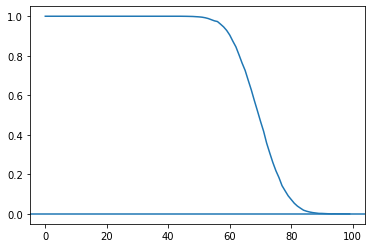

In [21]:
times_alpha_to_errB = [timind[np.argmin(np.abs(alpha[indb,:] - errs[indb]))] for indb in range(len(boundsB))]
indb = -1
ax=plt.subplot(111)
ax.plot(alpha[indb,:])
ax.axhline(avg_err_alpha(boundsB[-1]))

In [25]:
times_alpha_to_errB = [timind[np.argmin(np.abs(alpha[indb,:] - errs[indb]))] for indb in range(len(boundsB))]
times_beta_to_errB = [timind[np.argmin(np.abs(beta[indb,:] - errs[indb]))] for indb in range(len(boundsB))]

In [26]:
times_alpha_to_errB/stopping_0

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       53.        ,  9.76587771,  7.09475283,  5.69363815,  5.10796274,
        4.56424575,  4.35694932,  4.09463926,  3.98392475,  3.82190074,
        3.71351314,  3.95107532,  4.00198838,  3.84285125,  3.99315273,
        3.90099309,  3.84568487,  3.82946293,  4.1078703 ,  4.11535146,
        3.88691164,  4.21222111,  4.26606069,  4.34531644,  4.15290692,
        4.26050099,  4.37324216,  4.20550763,  4.33798109,  4.46

In [27]:
times_beta_to_errB/stopping_0

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       5.00000000e+01, 5.31476338e+00, 2.94364367e+00, 3.79575877e+00,
       2.78169089e+00, 1.89775766e+00, 1.69283421e+00, 1.48666150e+00,
       1.18131015e+00, 1.05961750e+00, 8.99449303e-01, 1.53508269e+00,
       1.35845686e+00, 1.21922553e+00, 1.18431179e+00, 1.08141120e+00,
      

In [28]:
plt.figure(figsize=(5,10))

ax = plt.subplot(311)
k=8
boundsplot = boundsB

ax.plot(errs, stopping_1, color="black", linewidth=3, label="stochastic")
ax.fill_between(errs, stopping_1 - std_stopping_1, stopping_1 + std_stopping_1, alpha=0.5)
#for indb, b in enumerate(boundsplot):
    
ax.plot(errs,times_alpha_to_errB , label="deterministic")
#ax.set_xscale("log")
ax.legend()
ax.set_xlabel("error")
ax.set_ylabel("time")



ax = plt.subplot(312)
k=8
boundsplot = boundsB

ax.plot(errs, stopping_1, color="black", linewidth=3, label="stochastic")
ax.plot(errs, stopping_1, color="black", linewidth=3, label="stochastic")
ax.fill_between(errs, stopping_1 - std_stopping_1, stopping_1 + std_stopping_1, alpha=0.5)
ax.plot(errs,times_alpha_to_errB)

ax.set_xscale("log")
ax.legend()
ax.set_xlabel("error")
ax.set_ylabel("time")


ax = plt.subplot(333)
k=8
ax.plot(errs, stopping_1)
ax.fill_between(errs, stopping_1 - std_stopping_1, stopping_1 + std_stopping_1, alpha=0.5)
for indb, b in enumerate(boundsplot):
    ax.plot(beta[indb,:][:-k], timind[:-k], label=r'$P_1 = \beta^{b}$'+"b = {}".format(np.round(b,2)))
#ax.set_xscale("log")
ax.legend()
ax.set_xlabel("error")
ax.set_ylabel("time")




ax = plt.subplot(313)
ax.plot(times_alpha_to_errB/stopping_0, '.-')
ax.set_yticks(np.arange(0,11,1))
ax.set_ylim([2,6])
ax.set_xlabel("error")
ax.set_ylabel("deterministic/stochastic")

Text(0, 0.5, 'deterministic/stochastic')

Error in callback <function flush_figures at 0x2ac0be59ea60> (for post_execute):


KeyboardInterrupt: 

In [29]:
pars = give_def_params_discrimination(flip=0, mode = "damping")
params, exp_path = check_params(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
mu1 = drift(kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)

gp1 = [ggiulio_prob(t, boundsB[-1], kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1) for t in timind]

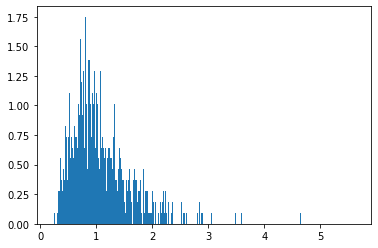

In [30]:
counts, bins, bars = plt.hist(stop1[:,-1], bins=int(len(stop1)/2), density=True)
times_histogram = 0.5*(bins[1:] + bins[:-1])-bins[0]


Text(0, 0.5, 'Stopping time probability')

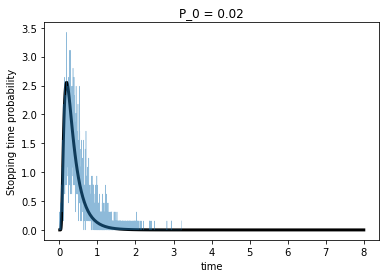

In [560]:
plt.title("P_0 = {}".format(np.round(errs[-1],2)))
plt.plot(timind,gp1, linewidth=3, color="black")
plt.plot(times_histogram, counts, linewidth=0.5, alpha=0.5)
plt.xlabel("time")
plt.ylabel("Stopping time probability")

In [31]:
binsize = bins[1]-bins[0]
np.sum(counts*bins[1:])*binsize

1.0854531441942585

In [610]:
(boundsB[-1]/mu0)/stopping_0[-1]

0.6945454971138855

In [624]:
std/std_stopping_1[-1]

0.5818184927577108

In [606]:
(boundsB[-1]/mu0)**2

0.13721154920350465

In [35]:
b=boundsB[-1]
sigg = b*(1+b)/(mu1**2)
std = np.sqrt(sigg - (boundsB[-1]/mu1)**2)
std, std_stopping_1[-1]

(0.26440918790407575, 0.5393524653066954)

In [99]:
tts=times[::100]
ind = len(boundsB)-1
b = boundsB[ind]
alph = np.array([.5*(1 - erf((-b + mu0*t)/(2*np.sqrt(mu1*t)))) for t in tts])

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


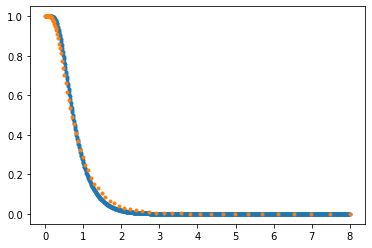

In [113]:
ax=plt.subplot(111)
ax.plot(tts,alph,'.')
ax.plot([times[i] for i in indis], alpha[ind-14,:],'.')


Loading old data


In [114]:
dirr = "/data/uab-giq/scratch/matias/quantera/trajectories/hypothesis_testing/damping_disc_unamed/set2_dt1e-5/"

In [191]:
alphaset2 = np.load(dirr+"alpha_deter.npy", allow_pickle=True)
betaset2 = np.load(dirr+"beta_deter.npy", allow_pickle=True)

boundsB2 = np.load(dirr+"boundsB.npy")
times2 = np.arange(0,4+1e-5,1e-5)

indis2 = np.logspace(2,np.log10(len(times2)-1), 50)
indis2 = [int(k) for k in indis2]
timindis2 = [times2[i] for i in indis2]

In [193]:
alphaset2 = np.stack(list(alphaset2.item().values()))
betaset2 = np.stack(list(betaset2.item().values()))

In [187]:
ind = -1
b = boundsB2[ind]
alph = np.array([.5*(1 - erf((-b + mu0*t)/(2*np.sqrt(mu1*t)))) for t in times2])

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


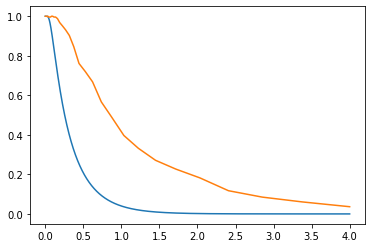

In [194]:
plt.plot(times2,alph)
plt.plot(timindis2, alphaset2[-1,:])

array([[0.37246964, 0.36842105, 0.37651822, 0.3805668 , 0.38461538,
        0.39271255, 0.39271255, 0.39676113, 0.44534413, 0.43724696,
        0.41295547, 0.4048583 , 0.44129555, 0.46558704, 0.44939271,
        0.40080972, 0.42105263, 0.40080972, 0.39271255, 0.39271255,
        0.37651822, 0.38461538, 0.3805668 , 0.36437247, 0.3562753 ,
        0.32793522, 0.33198381, 0.37246964, 0.32388664, 0.31578947,
        0.29149798, 0.27935223, 0.26720648, 0.26315789, 0.23076923,
        0.23076923, 0.18218623, 0.1417004 , 0.10526316, 0.09311741,
        0.10121457, 0.10526316, 0.09311741, 0.06882591, 0.07287449,
        0.03238866, 0.02024291, 0.01619433, 0.0242915 , 0.01619433],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99595142, 0.99595142, 0.96761134, 0.94736842, 0.93117409,
        0.91497976, 0.90688259, 0.86639676, 0.81376518, 0.7854251 ,
        0.8097166 , 0.74493927, 0.67206478, 0.65182186, 0.62753036,
        0.62348178, 0.55870445, 0.55060729, 0.5

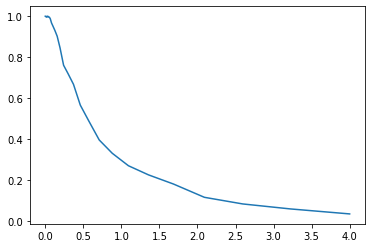

In [159]:
plt.plot(ltt, aaal1[-1,:])

In [2]:
stopping_1

NameError: name 'stopping_1' is not defined

In [129]:

ax = plt.subplot(133)
k=8
ax.plot(errs, stopping_1)
ax.fill_between(errs, stopping_1 - std_stopping_1, stopping_1 + std_stopping_1, alpha=0.5)
for indb, b in enumerate(boundsplot):
    ax.plot(beta[indb,:][:-k], timind[:-k], label=r'$P_1 = \beta^{b}$'+"b = {}".format(np.round(b,2)))
#ax.set_xscale("log")
ax.legend()
ax.set_xlabel("error")
ax.set_ylabel("time")

Text(0, 0.5, 'time')

Error in callback <function flush_figures at 0x2ac0be59ea60> (for post_execute):


Exception ignored in: <generator object _setattr_cm at 0x2ac0d0cd6d58>
Traceback (most recent call last):
  File "/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/matplotlib/cbook/__init__.py", line 2080, in _setattr_cm
KeyboardInterrupt: 

KeyboardInterrupt



In [201]:
beta[-1,:]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9974587 , 0.99618806, 0.99237611, 0.98221093, 0.97712834,
       0.94027954, 0.89580686, 0.83989835, 0.75730623, 0.65819568,
       0.52858958, 0.41296061, 0.30622618, 0.19440915, 0.12833545,
       0.08259212, 0.03939009, 0.01778907, 0.00635324, 0.0025413 ,
       0.0025413 , 0.00127065, 0.00127065, 0.00127065, 0.        ])

In [202]:
alpha[-1,:]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9974587 , 0.99618806, 0.99237611, 0.98221093, 0.97712834,
       0.94027954, 0.89580686, 0.83989835, 0.75730623, 0.65819568,
       0.52858958, 0.41296061, 0.30622618, 0.19440915, 0.12833545,
       0.08259212, 0.03939009, 0.01778907, 0.00635324, 0.0025413 ,
       0.0025413 , 0.00127065, 0.00127065, 0.00127065, 0.        ])

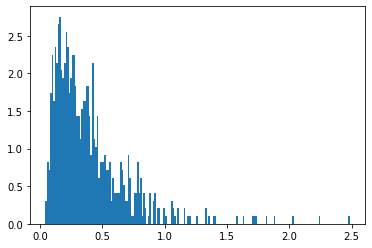

In [140]:
ii = 3
lastt = [stopps0[k][ii] for k in range(len(stopps0))]
counts, bins, bars = plt.hist(lastt, bins=int(len(lastt)/4), density= True)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
gp1 = [ggiulio_prob(t, boundsB[ii], kappa0, kappa1, eta0, eta1, n0, n1, gamma0,gamma1) for t in timind]

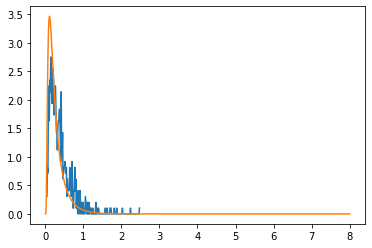

In [141]:
plt.plot(0.5*(bins[1:]+bins[:-1]), counts)
plt.plot(timind, gp1)

In [143]:
np.sum(lastt)/len(lastt)

0.38821527816845625

In [145]:
np.mean(lastt)

0.38821527816845625

0.28402102843619376

In [147]:
np.mean(counts)

0.4094501085042787

In [113]:
np.mean(counts)

0.3903657727290472

In [108]:
boundsB[4]/mu

0.37869470458159166

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


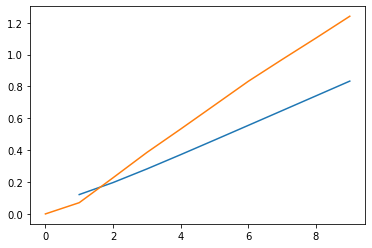

In [43]:
plt.plot(np.abs(np.log(np.array([avg_err_alpha(b) for b in boundsB])))/mu)
plt.plot(0.5*(stop_time0 + stop_time1))

In [ ]:
ax = plt.subplot(111)
ax.plot(alpha[-1,:],timind,'.')
ax.plot([avg_err_alpha(b) for b in boundsB],[times[int(np.argmin(np.abs(times - ss)))] for ss in stop_time0])
ax.plot([avg_err_alpha(b) for b in boundsB],4*np.array([times[int(np.argmin(np.abs(times - ss)))] for ss in stop_time0]))

ax.set_xscale("log")

In [26]:
times_det_alpha_is_b = np.zeros((alpha.shape[0], len(boundsB)))
for contour, bo in enumerate(range(alpha.shape[0])):
    times_det_alpha_is_b[contour] = [times[int(i)] for i in indis_alpha_is_b[contour]]

In [90]:
timind = [times[ind] for ind in indis]

In [89]:
#plt.plot(timind, [avg_err_alpha(b) for b in boundsB])
plt.plot(timind, alpha[0,:])
plt.plot(stop_time0, [avg_err_alpha(b) for b in boundsB])

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


Error in callback <function flush_figures at 0x2afd67df4840> (for post_execute):


KeyboardInterrupt: 

In [35]:
indis_alpha_is_b[-1,:]

array([ 0., 45., 45., 45., 45., 45., 45., 46., 46., 46., 46., 46., 46.,
       47., 47., 47., 47., 47., 47., 47., 47., 48., 48., 48., 48., 48.,
       48., 48., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49.])

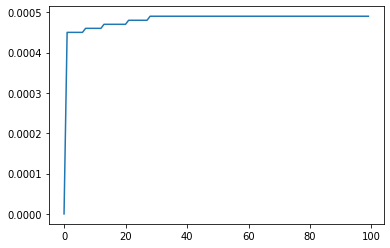

In [29]:
plt.plot(times_det_alpha_is_b[-1])
#plt.plot(stop_time0)

In [ ]:
for itraj in tqdm(range(2,3000)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
        stop["h0/h1"][itraj] = []
        stop["h1/h0"][itraj] = []
        ll += log_lik_ratio
        ll0+= log_lik_ratio_swap
        n+=1
        for ind, time_index in enumerate(indis):
            h0_deter = log_lik_ratio[time_index] <= 0
            h1_deter = log_lik_ratio_swap[time_index] <= 0
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
            
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
        for b in boundsB:
            stop["h0/h1"][itraj].append(get_stop_time(log_lik_ratio, b))
            stop["h1/h0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))


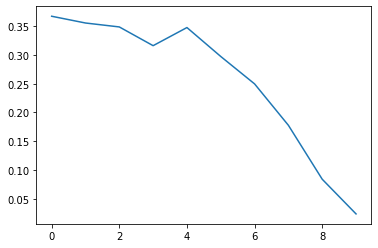

In [24]:
plt.plot(np.array(deter["h1/h0"]))

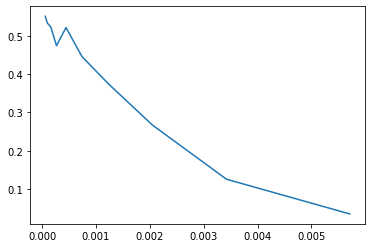

In [21]:
plt.plot([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]))

NameError: name 'ind_max_traj' is not defined

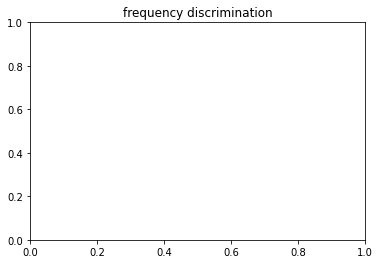

In [120]:
ax = plt.subplot(111)
plt.title("frequency discrimination")
lin=6
ax.plot(stop_time1, [avg_err_alpha(b) for b in boundsB[:len(stopps1[ind_max_traj])]], '.',label=r'$\langle \tau \rangle_{|H1}$', linewidth=lin)
ax.plot(stop_time0, [avg_err_alpha(b) for b in boundsB[:len(stopps0[ind_max_traj])]], '.',label=r'$\langle \tau \rangle_{|H0}$', linewidth=lin)
ax.plot([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]),color="black", label="deterministic")
ax.scatter([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]), color="black")

ax.set_xlabel("time")
ax.set_ylabel(r'$P_e = \frac{1}{2} (\alpha + \beta)$')
ax.legend(prop={"size":15})

In [471]:
ll *= len(stop["h0/h1"])**2
ll0 *= len(stop["h0/h1"])**2

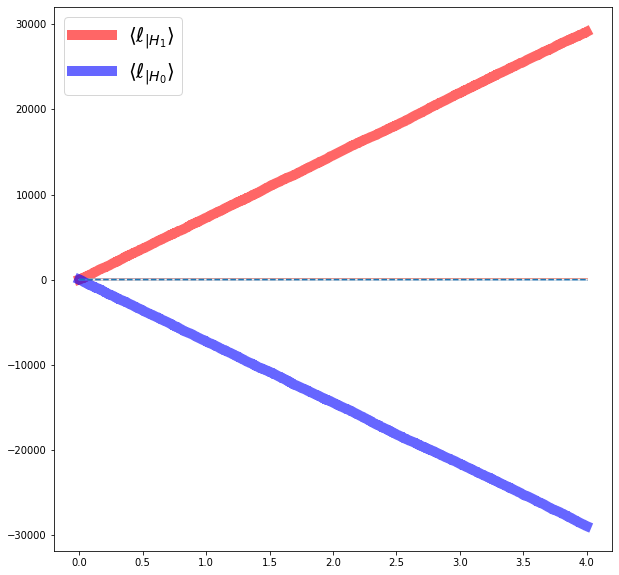

In [14]:

colors1 = plt.get_cmap("Reds")
colors0 = plt.get_cmap("Blues")

plt.figure(figsize=(10,10))
alphaMean=0.6
plt.plot(times, ll[:-1],linewidth=10, alpha=alphaMean,  color="red", label=r'$\langle \ell_{|H_1}\rangle$')
Ntraj = 10
c1 = colors1(np.linspace(0,1,Ntraj))[::-1]
c0 = colors0(np.linspace(0,1,Ntraj))[::-1]
             
for ii, itraj in enumerate(range(1,Ntraj)):
    log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
    plt.plot(times,log_lik_ratio[:-1], c=c1[ii], alpha=0.75)
    plt.plot(times, log_lik_ratio_swap[:-1],c=c0[ii], alpha=0.75)
plt.plot(times,ll0[:-1], linewidth=10, alpha=alphaMean, color="blue", label=r'$\langle \ell_{|H_0}\rangle$')
plt.plot(times, np.zeros(len(ll0)-1),"--")

plt.legend(prop={"size":20})

In [476]:
import os 
freq_dir = get_def_path(mode="continuous")+"freq_discrimination/"
os.makedirs(freq_dir, exist_ok=True)

np.save(freq_dir+"mean_likelihood_0", ll0)
np.save(freq_dir+"mean_likelihood_1", ll)
np.save(freq_dir+"boundsB", boundsB)
np.save(freq_dir+"stop_time1",stop_time1)
np.save(freq_dir+"stop_time0",stop_time0)
np.save(freq_dir+"alpha_deter",np.array(deter["h0/h1"]))
np.save(freq_dir+"beta_deter",np.array(deter["h1/h0"]))